## Deduplication of review dataset

We are using a deduplication by DOI.

In [1]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read initial data
dfReviewScopusOriginal = pd.read_csv('bulk_data/review_scopus.csv')
dfReviewWOSOriginal = pd.read_csv('bulk_data/review_wos.csv', delimiter='\t')

## Fill source for WoS papers
dfReviewWOSOriginal['source'] = 'Web of Science'

## Remove papers without DOI
dfReviewScopus = dfReviewScopusOriginal[dfReviewScopusOriginal['DOI'].notnull()]
dfReviewWOS = dfReviewWOSOriginal[dfReviewWOSOriginal['DI'].notnull()]

# Print size of dataframes and removed papers
removed_scopus = len(dfReviewScopusOriginal) - len(dfReviewScopus)
removed_WOS = len(dfReviewWOSOriginal) - len(dfReviewWOS)
print('Scopus len:', len(dfReviewScopus), ', removed', removed_scopus, 'without DOI')
print('WoS len:', len(dfReviewWOS), 'removed', removed_WOS, 'without DOI')

# Print columns name
print('Scopus columns:', dfReviewScopus.columns.values)
print('WoS columns:', dfReviewWOS.columns.values)

Scopus len: 916 , removed 25 without DOI
WoS len: 873 removed 11 without DOI
Scopus columns: ['Authors' 'Author(s) ID' 'Title' 'Year' 'Source title' 'Volume' 'Issue'
 'Art. No.' 'Page start' 'Page end' 'Page count' 'Cited by' 'DOI' 'Link'
 'Affiliations' 'Authors with affiliations' 'Abstract' 'Author Keywords'
 'Index Keywords' 'References' 'Editors' 'Publisher'
 'Language of Original Document' 'Document Type' 'Publication Stage'
 'Open Access' 'Source' 'EID']
WoS columns: ['PT' 'AU' 'BA' 'BE' 'GP' 'AF' 'BF' 'CA' 'TI' 'SO' 'SE' 'BS' 'LA' 'DT'
 'CT' 'CY' 'CL' 'SP' 'HO' 'DE' 'ID' 'AB' 'C1' 'C3' 'RP' 'EM' 'RI' 'OI'
 'FU' 'FP' 'FX' 'CR' 'NR' 'TC' 'Z9' 'U1' 'U2' 'PU' 'PI' 'PA' 'SN' 'EI'
 'BN' 'J9' 'JI' 'PD' 'PY' 'VL' 'IS' 'PN' 'SU' 'SI' 'MA' 'BP' 'EP' 'AR'
 'DI' 'DL' 'D2' 'EA' 'PG' 'WC' 'WE' 'SC' 'GA' 'PM' 'OA' 'HC' 'HP' 'DA'
 'UT' 'source']


In [3]:
# Rename columns

columns_scopus = [
    'Title', 'Authors', 'DOI', 'Source title', 'Year', 'Cited by', 
    'Author Keywords', 'Affiliations', 'Abstract', 'References', 'Publisher', 'ISSN', 
    'Language of Original Document', 'Document Type', 'Source'
]

columns_wos = [
    'TI', 'AU', 'DI', 'SO', 'PY', 'Z9', 
    'DE', 'C3', 'AB', 'CR', 'PU', 'SN', 
    'LA', 'DT', 'source'
]

final_columns = [
    'title', 'authors', 'DOI', 'journal_name', 'year', 'number_citation', 
    'author_keywords', 'affiliations', 'abstract', 'references', 'publisher', 'ISSN', 
    'language', 'document_type', 'source'
]

drop_columns = set(dfReviewScopus.columns.values) - set(columns_scopus)
rename_columns = dict(zip(columns_scopus, final_columns))
dfReviewScopus = dfReviewScopus.drop(columns=drop_columns)
dfReviewScopus = dfReviewScopus.rename(columns=rename_columns)

drop_columns = set(dfReviewWOS.columns.values) - set(columns_wos)
rename_columns = dict(zip(columns_wos, final_columns))
dfReviewWOS = dfReviewWOS.drop(columns=drop_columns)
dfReviewWOS = dfReviewWOS.rename(columns=rename_columns)

In [4]:
# If the paper is duplicated in the databases complete missing values from Scopus using WoS. 
# Also mark duplicated papers.

for idx, row in dfReviewScopus.iterrows():
    dfReviewWOSDuplicate = dfReviewWOS.loc[dfReviewWOS['DOI']== row.DOI]
    
    if not dfReviewWOSDuplicate.empty:
        dfReviewScopus.loc[idx, 'source'] = 'Scopus;Web of Science'

        if pd.isna(row['year']) and pd.notna(dfReviewWOSDuplicate['year'].values[0]): 
            dfReviewScopus.loc[idx, 'year'] = dfReviewWOSDuplicate['year'].values[0]
        if pd.isna(row['author_keywords']) and pd.notna(dfReviewWOSDuplicate['author_keywords'].values[0]): 
            dfReviewScopus.loc[idx, 'author_keywords'] = dfReviewWOSDuplicate['author_keywords'].values[0]
        if pd.isna(row['number_citation']) and pd.notna(dfReviewWOSDuplicate['number_citation'].values[0]): 
            dfReviewScopus.loc[idx, 'number_citation'] = dfReviewWOSDuplicate['number_citation'].values[0]

# Merge dataframes and remove duplicates by DOI 
dfReview = pd.concat([dfReviewScopus, dfReviewWOS], ignore_index=True)[final_columns]
dfReview = dfReview.drop_duplicates(subset=['DOI'], keep='first')

In [5]:
# Cleaning dataframe before saving

# Add date of export
dfReview['date_export'] = '2023-03-08'

# Add link from DOI
dfReview['link'] = 'https://dx.doi.org/' + dfReview['DOI']

# Reset index
dfReview.reset_index(drop=True, inplace=True)

In [6]:
# Print length of final dataset
print('Final length:', len(dfReview))

# Save dataset
dfReview.to_csv('data/meta_review.csv', index_label='index')

Final length: 1199


## Computing basic statistics of meta-review dataset

In [7]:
sns.set_context(rc = {'patch.linewidth': 0.0})

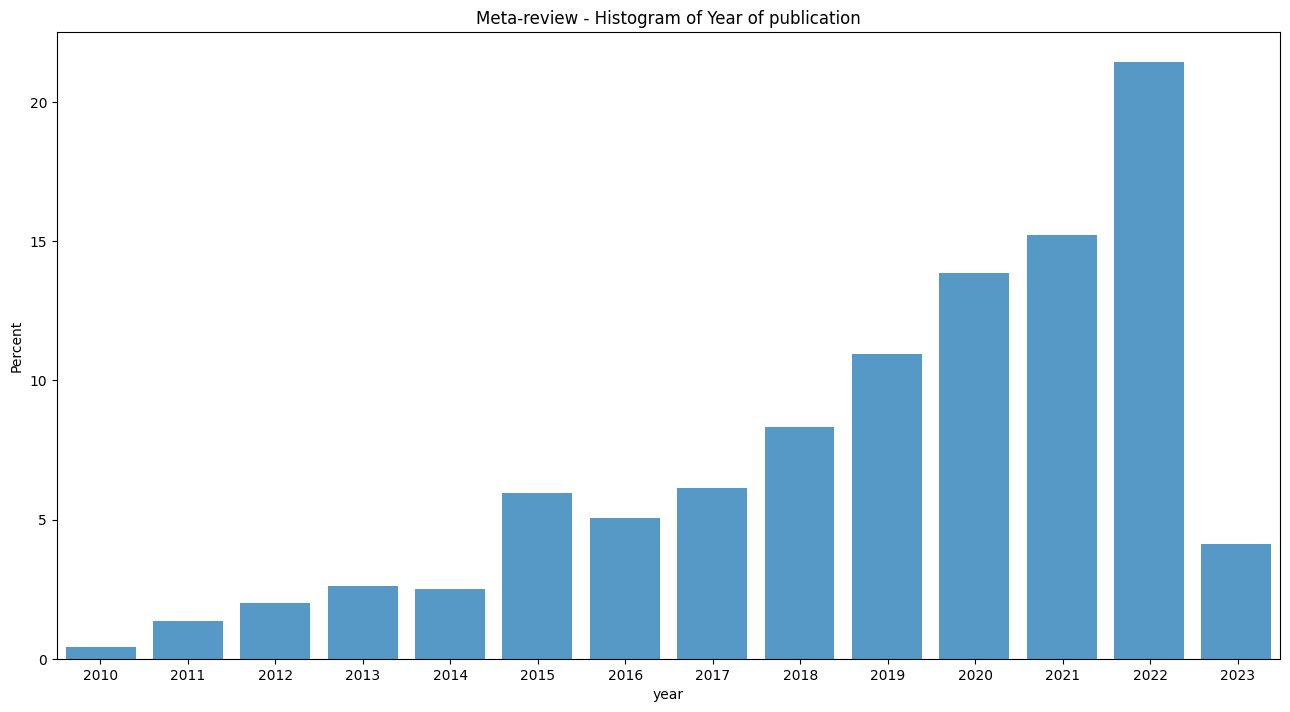

In [8]:
plt.figure(figsize=(13, 7))
sns.histplot(data=dfReview[dfReview.year.notnull()], x='year', stat='percent', bins=14, shrink=.8)

plt.xticks(np.arange(2010.46, 2023.0, step=0.93), np.arange(2010, 2024, step=1)) 
plt.xlim(2010, 2023)
plt.tight_layout()
plt.title('Meta-review - Histogram of Year of publication')
plt.show()

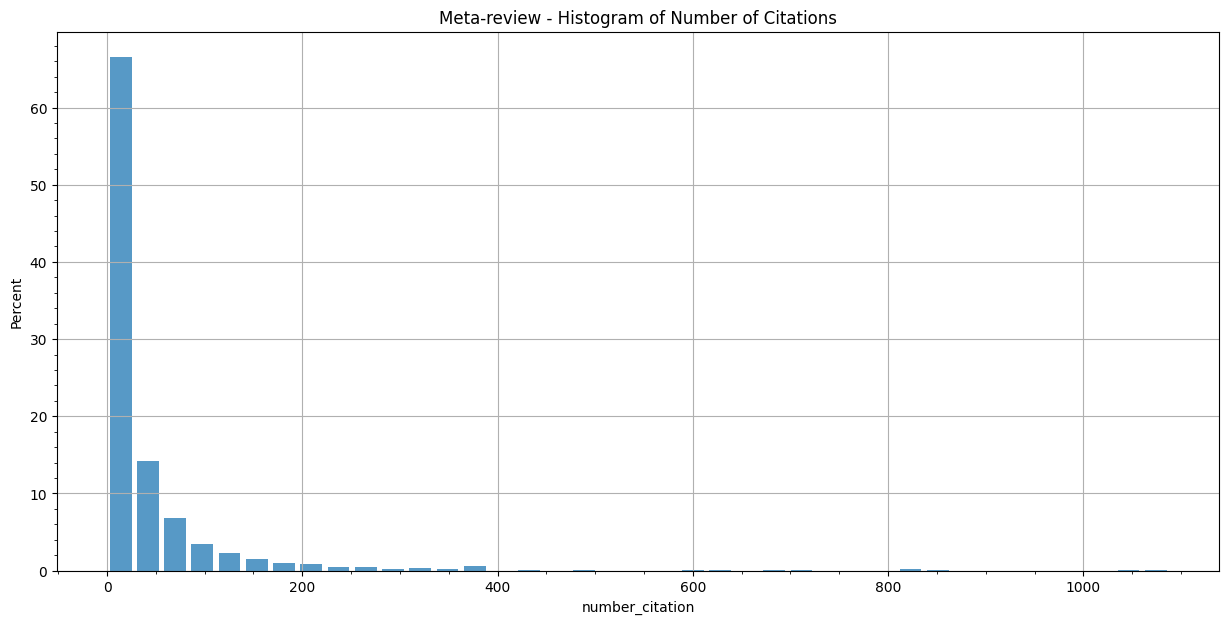

More than  200 citations 47
Removing less than 5 citations:  318 papers


In [9]:
cut_line = 200

plt.figure(figsize=(15, 7))

sns.histplot(
    data=dfReview[dfReview['number_citation'].notnull()], x='number_citation', stat='percent', bins=39, shrink=.8
)

plt.title('Meta-review - Histogram of Number of Citations')
plt.minorticks_on()
plt.grid()
plt.show()

print('More than ', cut_line, 'citations', (dfReview['number_citation'] > cut_line).sum())
print('Removing less than 5 citations: ', len(dfReview) - 881, 'papers')